# **<center>Action Recognition from Videos using Recurrent Neural Networks</center>**

The objective of this exercise is to classify the type of action being executed in videos.

The UCF101 dataset will be used. Four classes: Basketball, Diving, Golf Swing, Skiing

* 140 videos for training. Approximately 40 videos for each class. Each video has 40 frames.

* 400 videos for testing. Approximately 100 videos for each class. Each video has 40 frames.





# **<center>Network Architecture</center>**



Each frame is passed to a CNN encoder. The result is flattened and passed to the RNN network. We take the last output of the sequence to produce the final classification result

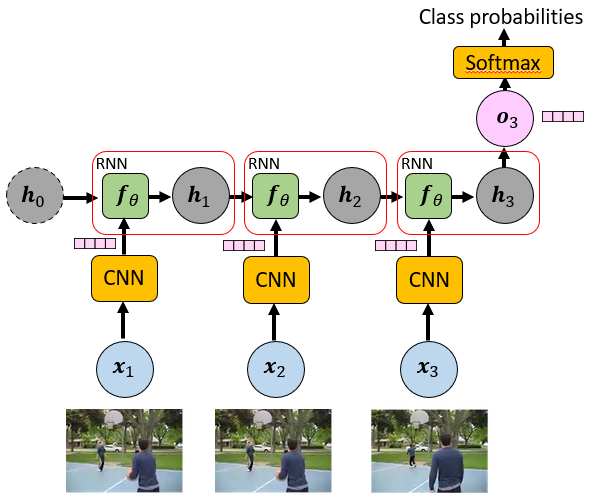

Each frame is passed to a pre-trained, frozen VGG16 encoder. Global Average Pooling (GAP) is applied to the resulting sequence of feature maps, producing a sequence of feature vectors. The sequence is passed to a many-to-one LSTM, followed by a dense network with softmax activation for the final class probabilities 

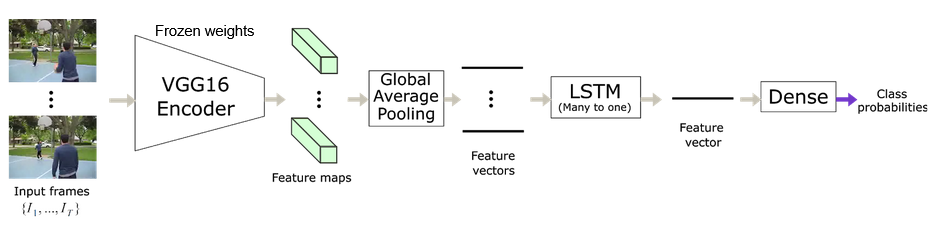

## **<center>VGG Encoder</center>**

The VGG16 encoder is used with ImageNet pre-trained weights.

The encoder is **indepentently** applied to **each frame** in the input video.

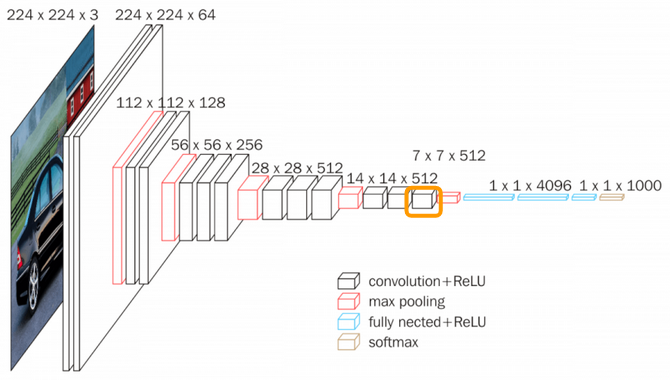

## **<center>Global average pooling (GAP)</center>**

The encoder output is passed to a GAP layer. It obtains the spatial global average value for each channel in the feature map.

GAP is **independently applied** to **each feature map** in the sequence.

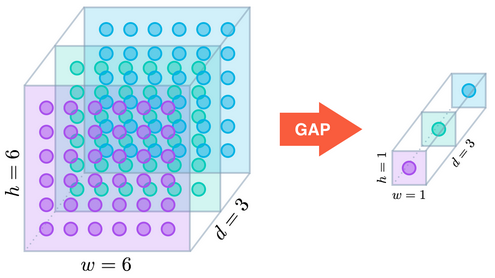

## **<center>Many-to-one LSTM (N-to-1)</center>**

The sequence of feature vectors is passed to a LSTM. We only take the latest element in the resulting sequence. Then we apply a Dense layer with softmax activation function for the final class probabilities 

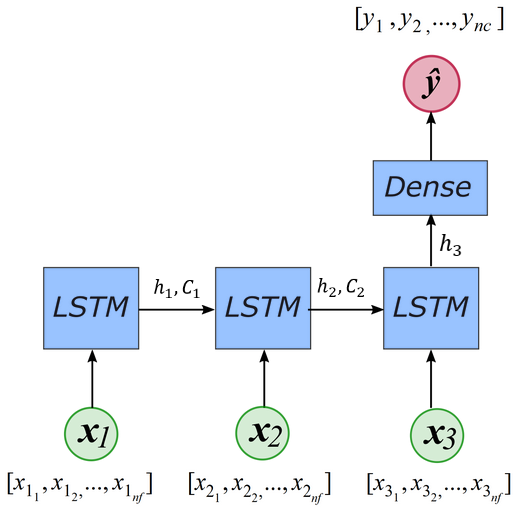

In [ ]:
!pip install scikit-video
!pip install icecream
!pip install -q git+https://github.com/tensorflow/docs
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 14.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.layers import GlobalAveragePooling2D
from keras import Model
import tensorflow as tf

import skvideo.io
import skvideo.datasets
import glob

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Input
from keras.models import Model
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import time

import pandas as pd


from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import imageio
from tensorflow_docs.vis import embed
import cv2
import os
%matplotlib inline
import pathlib
# fix random seed for reproducibility
np.random.seed(7)

import tensorflow
tensorflow.random.set_seed(3)

t0 = time.time()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **<center>Dataset loading and preprocessing</center>**

We will be using the UCF101 action recognition dataset. 4 classes were selected: Basketball, Diving, GolfSwing, Skiing

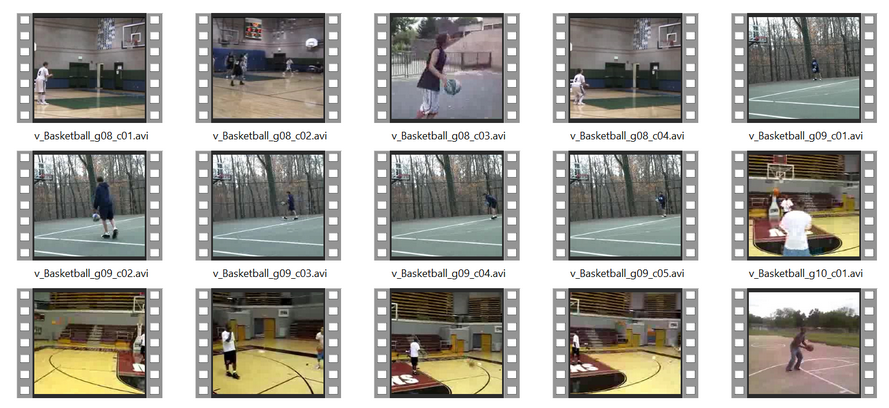

## **<center>Download the videos</center>**



In [ ]:
t0=time.time()
os.getcwd()

path = '/content/gdrive/My Drive/RNN_exercise'
pathlib.Path(path).mkdir(parents=True, exist_ok=True)
os.chdir(path)
# Download the videos
!gdown --i 1_qRKzrIVJ8vHVpM9lMuvrcjzUzp_9NuY

!unzip -n /content/gdrive/My\ Drive/RNN_exercise/Videos.zip -d .

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1_qRKzrIVJ8vHVpM9lMuvrcjzUzp_9NuY
To: /content/gdrive/My Drive/RNN_exercise/Videos.zip
100% 208M/208M [00:01<00:00, 113MB/s]
Archive:  /content/gdrive/My Drive/RNN_exercise/Videos.zip


In [ ]:
!ls
!ls Videos/Testing
!ls Videos/Training


50_LSTM.h5     LSTM_100.h5  LSTM_500.h5		     Videos
animation.gif  LSTM_200.h5  pretrained_features.npz  Videos.zip
Basketball  Diving  GolfSwing  Skiing
Basketball  Diving  GolfSwing  Skiing


## **<center>Prepare the dataset</center>**
* Train test split
* Define the frame number = 40
* Convert labels to one-hot encoding



In [ ]:

# This function assigns the corresponding class labels to each sample
def dataset_build(data_path, classes, set_):
  set_file_count=len(glob.glob(data_path+set_+'/**/*.avi',recursive=True))
  print(set_+" file count:",set_file_count)
  X_filenames=[]
  Y=np.zeros(set_file_count)
  sample_id=0
  for clss_name,clss_idx in zip(classes,range(len(classes))):
    clss_file_list=glob.glob(data_path+set_+'/'+clss_name+'/*.avi')
    X_filenames+=clss_file_list
    print("debug: sample_id={}, len(clss_file_list)={}".format(sample_id,clss_file_list))
    Y[sample_id:sample_id+len(clss_file_list)]=clss_idx # Assing labels to samples from each class
    sample_id+=len(clss_file_list)
  return X_filenames, Y

data_path='Videos/'
classes=['Basketball','Diving','GolfSwing','Skiing']
t_len, feature_len, class_n = 40, 512, len(classes)
X_filenames_test,Y_test=dataset_build(data_path, classes, set_='Testing')
X_filenames_train,Y_train=dataset_build(data_path, classes, set_='Training')

print("Train class unique values",np.unique(Y_train,return_counts=True))
print("Test class unique values",np.unique(Y_test,return_counts=True))
print("Classes:",classes)

# Set labels to one-hot 
Y_train=np_utils.to_categorical(Y_train)
Y_test=np_utils.to_categorical(Y_test)



Testing file count: 159
debug: sample_id=0, len(clss_file_list)=['Videos/Testing/Basketball/v_Basketball_g01_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c04.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c06.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c05.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c07.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c05.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c04.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c06.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c04.avi', 'Videos/Testing/B

# **<center>Define the pre-trained model and extract features</center>**


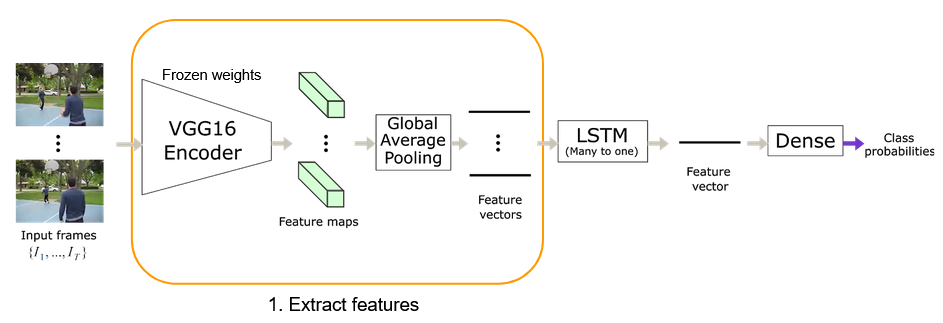

## Specify the pre-trained encoder architecture

In [ ]:

def get_model():

    # YOU: Create the VGG16 encoder with imagenet pre-trained weights
    # HINT: Drop the softmax classification layer and use GlobalAveragePooling2D instead. 

    model = VGG16(include_top  = False        ,
                  weights      = "imagenet"   ,
                  input_tensor = None         ,
                  input_shape  = (224, 224, 3),
                  pooling      = "avg"        ) 
  

    return model

def extract_features(video_path, model, num_frames=40):

    '''
    1. Loads a video as videogen 
    2. Extracts features from VGG16 CNN encoder model for each frame in vgg16_feature

    Arguments

    video_path: path to the video file.
    model: VGG16 CNN encoder model.
    num_frames: number of frames in the video. Each video has 40 frames.

    Return value

    Returned value is of shape (t_len, feature_len)
    '''
    # Load the video
    if video_path is None:
        video_path = skvideo.datasets.bigbuckbunny()
    videogen = skvideo.io.vreader(video_path)
    vgg16_feature = []

    # Extract features for each frame
    for i in range(num_frames):
        # print(frame.shape)
        frame_crop = next(videogen)[:224,:224]
        
        img_data = np.expand_dims(frame_crop, axis=0)
        img_data = preprocess_input(img_data) # Covert from RGB to BGR. Then subtract ImageNet mean value

        vgg16_feature.append(model.predict(img_data))

    return np.squeeze(np.array(vgg16_feature))

In [ ]:
cnnModel = get_model()

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
cnnModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Extract features from the pre-trained model

In [ ]:
# Creates a function for extracting features for all videos training and testing
# Features extracted from CNN correspond to X_train and X_test variables

import pdb

def extract_features_from_set(cnnModel, X_filenames, X):

  # YOU: Extract features for each video filename
  # HINT: Use extract_features() function for each video.
  # X should be of shape (sample_id, t_len, feature_len)

  #range(len(X_filenames))

  for index in range(len(X_filenames)):
    
    features = extract_features(X_filenames[index], cnnModel, num_frames=40)
    X[index] = features

  return X


load_pretrained_features_flag = True
pretrained_features_filename = path + '/pretrained_features.npz'

if load_pretrained_features_flag == False:

  X_train = np.zeros((Y_train.shape[0],t_len,feature_len))
  X_test = np.zeros((Y_test.shape[0],t_len,feature_len))
  print("X train shape:{}, X test shape:{}".format(X_train.shape,X_test.shape))

  print("Before extract features execution time: ",time.time()-t0)

  X_train = extract_features_from_set(cnnModel, X_filenames_train, X_train)
  print("Train features extracted")
  print(X_train.shape,X_test.shape)
  X_test = extract_features_from_set(cnnModel, X_filenames_test, X_test)
  print("Test features extracted")

  # Save extracted CNN features
  np.savez(pretrained_features_filename, x_test = X_test, x_train = X_train)
else:
  # CNN feature extraction takes about 25 minutes. 
  # After extracting for the first time, load the CNN features from file
  data = np.load(pretrained_features_filename)

  X_train = data['x_train']
  X_test = data['x_test']

print("X_train.shape={}, Y_train.shape={}".format(X_train.shape,Y_train.shape))
print("X_test.shape={}, Y_test.shape={}".format(X_test.shape,Y_test.shape))
  

X_train.shape=(399, 40, 512), Y_train.shape=(399, 4)
X_test.shape=(159, 40, 512), Y_test.shape=(159, 4)


# **<center>Define the trainable LSTM model</center>**
Define the LSTM block, and the final Dense layer with softmax. Also, define the training loss and optimizer

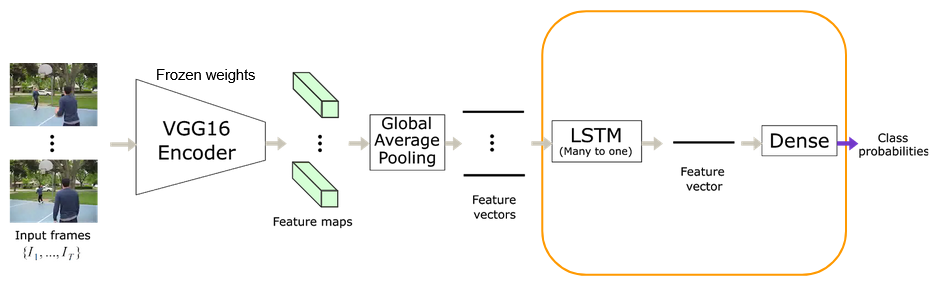

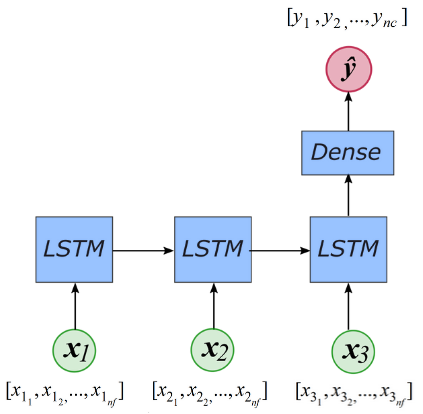

In [ ]:
print("Input shape: ({}, {})".format(t_len, feature_len))


def create_model(rnn_network = "LSTM",
                 internal_units = 50,
                 t_len = t_len ,
                 feature_len = feature_len):

      # YOU: Define the LSTM network in model variable. 
      # HINT: Input shape is (batch_size, t_len, feature_len), where t_len is the sequence length 
      #       and feature_len is the length of the features produced by the CNN encoder

      model = Sequential()

      if rnn_network == "LSTM":
        model.add(LSTM(internal_units, input_shape=(t_len, feature_len)))

      elif rnn_network == "GRU":
        model.add(GRU(internal_units, input_shape=(t_len, feature_len)))
      
      elif rnn_network == "Deep LSTM":
        model.add(LSTM(internal_units, input_shape=(t_len, feature_len), return_sequences = True))
        model.add(LSTM(internal_units, input_shape=(t_len, feature_len)))


      # Prediction Layer
      model.add(Dense(4, activation = 'softmax'))



      # YOU: Define training loss and optimizer.
      # HINT: Use categorical crossentropy loss and Adam optimizer.

      base_learning_rate = 0.0001
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                    loss= tf.keras.losses.CategoricalCrossentropy(),
                    metrics=['accuracy'])
      
      model.summary()

      return model


print("Before fit execution time: ",time.time()-t0)


Input shape: (40, 512)
Before fit execution time:  12.491958856582642


In [ ]:
model = create_model(rnn_network = "LSTM",
                 internal_units = 50,
                 t_len = t_len ,
                 feature_len = feature_len)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                112600    
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 112,804
Trainable params: 112,804
Non-trainable params: 0
_________________________________________________________________


# **<center>Train</center>** 

In [ ]:
def Train(model, 
          X_train,
          Y_train,
          file_name,
          batch_size = 128,
          epochs = 1000): 

    print('Start training')

    # create early stopp callbacks to stop training after not imporvment
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, 
                               mode = 'max', patience = 100)

    # YOU: Use early stopping.
    # HINT: Use the EarlyStopping callback and monitor the validation loss.
    model.fit(X_train, 
              Y_train, 
              epochs=epochs, 
              batch_size=batch_size, 
              validation_split = 0.1, 
              verbose=2,
              callbacks=[early_stop])
    

    model.save(file_name)
    

    print("execution time: ",time.time()-t0)

In [ ]:
Train(model,X_train,Y_train,batch_size = 128, file_name = "50_LSTM.h5")

Start training
Epoch 1/1000
3/3 - 7s - loss: 1.4593 - accuracy: 0.2535 - val_loss: 1.3445 - val_accuracy: 0.2750 - 7s/epoch - 2s/step
Epoch 2/1000
3/3 - 0s - loss: 1.3655 - accuracy: 0.3036 - val_loss: 1.3348 - val_accuracy: 0.3000 - 56ms/epoch - 19ms/step
Epoch 3/1000
3/3 - 0s - loss: 1.2838 - accuracy: 0.3760 - val_loss: 1.3156 - val_accuracy: 0.3000 - 55ms/epoch - 18ms/step
Epoch 4/1000
3/3 - 0s - loss: 1.2103 - accuracy: 0.4345 - val_loss: 1.2931 - val_accuracy: 0.3000 - 54ms/epoch - 18ms/step
Epoch 5/1000
3/3 - 0s - loss: 1.1447 - accuracy: 0.4958 - val_loss: 1.2687 - val_accuracy: 0.3000 - 53ms/epoch - 18ms/step
Epoch 6/1000
3/3 - 0s - loss: 1.0874 - accuracy: 0.5487 - val_loss: 1.2465 - val_accuracy: 0.4000 - 55ms/epoch - 18ms/step
Epoch 7/1000
3/3 - 0s - loss: 1.0320 - accuracy: 0.6212 - val_loss: 1.2290 - val_accuracy: 0.4250 - 54ms/epoch - 18ms/step
Epoch 8/1000
3/3 - 0s - loss: 0.9817 - accuracy: 0.6574 - val_loss: 1.2164 - val_accuracy: 0.4250 - 55ms/epoch - 18ms/step
Epoch


# **<center>Evaluate the model</center>**
Predict and estimate test set accuracy (accuracy_score)

In [ ]:
def compute_metrics(true_labels, predicted_labels):
  accuracy = 100*accuracy_score(true_labels, predicted_labels)
  f1score = 100*f1_score(true_labels, predicted_labels, average=None)
  f1score_avg = 100*f1_score(true_labels, predicted_labels, average='macro')

  return accuracy, f1score, f1score_avg

  
def Test_model(model,
               X_test,
               Y_test,
               printar = False):
        
    predict_labels = model.predict(X_test)
    # YOU: Make predictions on test data (X_test)
    # YOU: Obtain test set metrics: Overall accuracy, per-class F1 score, average F1 score
    # HINT: Use sklearn.metrics module


    predicted_labels = np.zeros(len(predict_labels))
    for index in range(len(predict_labels)):
      predicted_labels[index] = np.argmax(predict_labels[index])

    
    accuracy, f1score, f1score_avg = compute_metrics(np.where(Y_test)[1], predicted_labels)

    if printar:
      print("Accuracy: {} %".format(round(accuracy,2)))
      print("F1 Score Per-Class:{}".format(f1score))
      print("F1 Score Average:{} %".format(round(f1score_avg,2)))




    return accuracy, f1score, f1score_avg




In [ ]:
#model = tf.keras.models.load_model("50_LSTM.h5")

accuracy, f1score, f1score_avg = Test_model(model,X_test,Y_test, printar = True)

Accuracy: 94.97 %
F1 Score Per-Class:[ 91.89189189 100.          92.10526316  94.87179487]
F1 Score Average:94.72 %


## **<center>Sample test predictions</center>**
Plot test predictions for the final model

(111, 224, 224, 3)
Classification result for video ID 25: Basketball



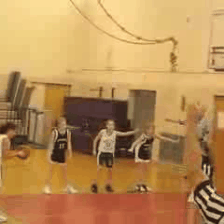

In [ ]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')


idx = np.random.randint(0, X_test.shape[0]) # Random ID from test set
sample_video = load_video(X_filenames_test[idx])

print(sample_video.shape)
sample_video = sample_video[:100]

# Make prediction on sample test video
prediction = model.predict(np.expand_dims(X_test[idx], axis=0))
prediction = np.squeeze(prediction)

print("Classification result for video ID {}: {}".format(idx, classes[prediction.argmax(axis=0)]))


# Display sample test video
to_gif(sample_video)

In [ ]:
print(time.time() - t0)

36.90762186050415


# **<center>Experiments</center>**

1. Use different LSTM internal units: 50, 100, 200, 500
2. Replace LSTM with GRU (count number of parameters)
3. Use a deep LSTM. Two stacked LSTM layers: The output of the first LSTM goes to the input of the second LSTM (Hint: The first LSTM should be configured as "N-to-N" using the parameter "return_sequences")

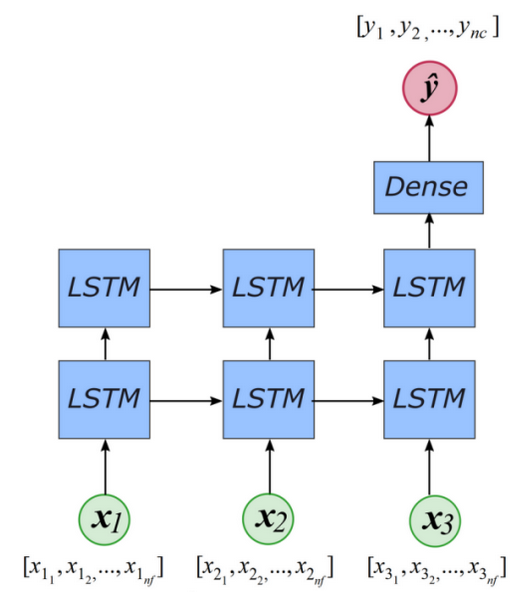

# Train Experiments

## LSTM 50

In [ ]:
lstm50 = create_model(rnn_network = "LSTM",
                      internal_units = 50,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(lstm50,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "50_LSTM.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                112600    
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 112,804
Trainable params: 112,804
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 2s - loss: 1.6106 - accuracy: 0.2953 - val_loss: 1.2816 - val_accuracy: 0.3750 - 2s/epoch - 700ms/step
Epoch 2/1000
3/3 - 0s - loss: 1.4787 - accuracy: 0.3370 - val_loss: 1.2829 - val_accuracy: 0.4000 - 56ms/epoch - 19ms/step
Epoch 3/1000
3/3 - 0s - loss: 1.3731 - accuracy: 0.3593 - val_loss: 1.2729 - val_accuracy: 0.3750 - 56ms/epoch - 19ms/step
Epoch 4/1000
3/3 - 0s - loss: 1.2816 - accuracy: 0.4206 - val

## LSTM 100

In [ ]:
lstm100 = create_model(rnn_network = "LSTM",
                      internal_units = 100,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(lstm100,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "LSTM_100.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               245200    
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 245,604
Trainable params: 245,604
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 2s - loss: 1.4454 - accuracy: 0.3036 - val_loss: 1.5297 - val_accuracy: 0.3000 - 2s/epoch - 644ms/step
Epoch 2/1000
3/3 - 0s - loss: 1.2920 - accuracy: 0.4067 - val_loss: 1.4717 - val_accuracy: 0.3000 - 76ms/epoch - 25ms/step
Epoch 3/1000
3/3 - 0s - loss: 1.1603 - accuracy: 0.5292 - val_loss: 1.4042 - val_accuracy: 0.3750 - 71ms/epoch - 24ms/step
Epoch 4/1000
3/3 - 0s - loss: 1.0499 - accuracy: 0.6156 - val

## LSTM 200

In [ ]:
lstm200 = create_model(rnn_network = "LSTM",
                      internal_units = 200,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(lstm200,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "LSTM_200.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200)               570400    
                                                                 
 dense_3 (Dense)             (None, 4)                 804       
                                                                 
Total params: 571,204
Trainable params: 571,204
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 2s - loss: 1.2671 - accuracy: 0.4178 - val_loss: 1.5449 - val_accuracy: 0.2250 - 2s/epoch - 696ms/step
Epoch 2/1000
3/3 - 0s - loss: 1.0261 - accuracy: 0.6323 - val_loss: 1.4064 - val_accuracy: 0.2750 - 80ms/epoch - 27ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.8492 - accuracy: 0.7772 - val_loss: 1.2449 - val_accuracy: 0.3750 - 76ms/epoch - 25ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.7012 - accuracy: 0.8858 - val

## LSTM 500

In [ ]:
lstm500 = create_model(rnn_network = "LSTM",
                      internal_units = 500,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(lstm500,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "LSTM_500.h5")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 500)               2026000   
                                                                 
 dense_4 (Dense)             (None, 4)                 2004      
                                                                 
Total params: 2,028,004
Trainable params: 2,028,004
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 2s - loss: 1.5343 - accuracy: 0.2228 - val_loss: 1.3686 - val_accuracy: 0.4250 - 2s/epoch - 643ms/step
Epoch 2/1000
3/3 - 0s - loss: 0.9422 - accuracy: 0.6880 - val_loss: 1.1484 - val_accuracy: 0.5500 - 126ms/epoch - 42ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.5916 - accuracy: 0.8969 - val_loss: 0.9110 - val_accuracy: 0.6750 - 108ms/epoch - 36ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.3840 - accuracy: 0.9499

## GRU 50

In [ ]:
gru50 = create_model(rnn_network = "GRU",
                      internal_units = 50,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(gru50,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "GRU_50.h5")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                84600     
                                                                 
 dense_5 (Dense)             (None, 4)                 204       
                                                                 
Total params: 84,804
Trainable params: 84,804
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 2s - loss: 2.2055 - accuracy: 0.2173 - val_loss: 1.0782 - val_accuracy: 0.4250 - 2s/epoch - 597ms/step
Epoch 2/1000
3/3 - 0s - loss: 2.0280 - accuracy: 0.2368 - val_loss: 1.1279 - val_accuracy: 0.4000 - 51ms/epoch - 17ms/step
Epoch 3/1000
3/3 - 0s - loss: 1.8716 - accuracy: 0.2674 - val_loss: 1.1743 - val_accuracy: 0.3500 - 50ms/epoch - 17ms/step
Epoch 4/1000
3/3 - 0s - loss: 1.7208 - accuracy: 0.3175 - val_l

## GRU 100

In [ ]:
gru100 = create_model(rnn_network = "GRU",
                      internal_units = 100,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(gru100,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "GRU_100.h5")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 100)               184200    
                                                                 
 dense_6 (Dense)             (None, 4)                 404       
                                                                 
Total params: 184,604
Trainable params: 184,604
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 2s - loss: 1.7720 - accuracy: 0.2173 - val_loss: 1.1821 - val_accuracy: 0.4250 - 2s/epoch - 702ms/step
Epoch 2/1000
3/3 - 0s - loss: 1.5210 - accuracy: 0.2841 - val_loss: 1.2151 - val_accuracy: 0.4500 - 59ms/epoch - 20ms/step
Epoch 3/1000
3/3 - 0s - loss: 1.3286 - accuracy: 0.3705 - val_loss: 1.2219 - val_accuracy: 0.4500 - 57ms/epoch - 19ms/step
Epoch 4/1000
3/3 - 0s - loss: 1.1735 - accuracy: 0.4930 - val

## GRU 200

In [ ]:
gru200 = create_model(rnn_network = "GRU",
                      internal_units = 200,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(gru200,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "GRU_200.h5")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 200)               428400    
                                                                 
 dense_7 (Dense)             (None, 4)                 804       
                                                                 
Total params: 429,204
Trainable params: 429,204
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 2s - loss: 1.6177 - accuracy: 0.2897 - val_loss: 2.4625 - val_accuracy: 0.1000 - 2s/epoch - 609ms/step
Epoch 2/1000
3/3 - 0s - loss: 1.2999 - accuracy: 0.3900 - val_loss: 2.1587 - val_accuracy: 0.1750 - 74ms/epoch - 25ms/step
Epoch 3/1000
3/3 - 0s - loss: 1.0539 - accuracy: 0.5125 - val_loss: 1.8781 - val_accuracy: 0.2000 - 75ms/epoch - 25ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.8515 - accuracy: 0.6713 - val

## GRU 500

In [ ]:
gru500 = create_model(rnn_network = "GRU",
                      internal_units = 500,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(gru500,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "GRU_500.h5")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 500)               1521000   
                                                                 
 dense_8 (Dense)             (None, 4)                 2004      
                                                                 
Total params: 1,523,004
Trainable params: 1,523,004
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 2s - loss: 1.3617 - accuracy: 0.3454 - val_loss: 1.5912 - val_accuracy: 0.2750 - 2s/epoch - 626ms/step
Epoch 2/1000
3/3 - 0s - loss: 0.8354 - accuracy: 0.6602 - val_loss: 0.9496 - val_accuracy: 0.5750 - 113ms/epoch - 38ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.5187 - accuracy: 0.8747 - val_loss: 0.5625 - val_accuracy: 0.8250 - 111ms/epoch - 37ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.3313 - accuracy: 0.9415

## Deep LSTM 50

In [ ]:
D_lstm50 = create_model(rnn_network = "Deep LSTM",
                      internal_units = 50,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(D_lstm50,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "Deep_LSTM_50.h5")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 40, 50)            112600    
                                                                 
 lstm_6 (LSTM)               (None, 50)                20200     
                                                                 
 dense_9 (Dense)             (None, 4)                 204       
                                                                 
Total params: 133,004
Trainable params: 133,004
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 3s - loss: 1.4089 - accuracy: 0.2423 - val_loss: 1.3332 - val_accuracy: 0.3750 - 3s/epoch - 1s/step
Epoch 2/1000
3/3 - 0s - loss: 1.3487 - accuracy: 0.3203 - val_loss: 1.3269 - val_accuracy: 0.4000 - 67ms/epoch - 22ms/step
Epoch 3/1000
3/3 - 0s - loss: 1.2946 - accuracy: 0.3983

## Deep LSTM 100

In [ ]:
D_lstm100 = create_model(rnn_network = "Deep LSTM",
                      internal_units = 100,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(D_lstm100,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "Deep_LSTM_100.h5")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 40, 100)           245200    
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 4)                 404       
                                                                 
Total params: 326,004
Trainable params: 326,004
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 4s - loss: 1.3893 - accuracy: 0.2813 - val_loss: 1.1994 - val_accuracy: 0.6500 - 4s/epoch - 1s/step
Epoch 2/1000
3/3 - 0s - loss: 1.2738 - accuracy: 0.4735 - val_loss: 1.1879 - val_accuracy: 0.7000 - 95ms/epoch - 32ms/step
Epoch 3/1000
3/3 - 0s - loss: 1.1729 - accuracy: 0.637

## Deep LSTM 200

In [ ]:
D_lstm200 = create_model(rnn_network = "Deep LSTM",
                      internal_units = 200,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(D_lstm200,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "Deep_LSTM_200.h5")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 40, 200)           570400    
                                                                 
 lstm_10 (LSTM)              (None, 200)               320800    
                                                                 
 dense_11 (Dense)            (None, 4)                 804       
                                                                 
Total params: 892,004
Trainable params: 892,004
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 3s - loss: 1.4554 - accuracy: 0.2340 - val_loss: 1.4533 - val_accuracy: 0.0500 - 3s/epoch - 1s/step
Epoch 2/1000
3/3 - 0s - loss: 1.2274 - accuracy: 0.4791 - val_loss: 1.4441 - val_accuracy: 0.0750 - 112ms/epoch - 37ms/step
Epoch 3/1000
3/3 - 0s - loss: 1.0502 - accuracy: 0.70

## Deep LSTM 500

In [ ]:
D_lstm500 = create_model(rnn_network = "Deep LSTM",
                      internal_units = 500,
                      t_len = t_len ,
                      feature_len = feature_len)

Train(D_lstm500,
      X_train,
      Y_train,
      batch_size = 128, 
      file_name = "Deep_LSTM_500.h5")

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 40, 500)           2026000   
                                                                 
 lstm_12 (LSTM)              (None, 500)               2002000   
                                                                 
 dense_12 (Dense)            (None, 4)                 2004      
                                                                 
Total params: 4,030,004
Trainable params: 4,030,004
Non-trainable params: 0
_________________________________________________________________
Start training
Epoch 1/1000
3/3 - 3s - loss: 1.2196 - accuracy: 0.5237 - val_loss: 1.0704 - val_accuracy: 0.6750 - 3s/epoch - 1s/step
Epoch 2/1000
3/3 - 0s - loss: 0.7044 - accuracy: 0.9164 - val_loss: 0.7437 - val_accuracy: 0.8750 - 150ms/epoch - 50ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.4071 - accuracy: 

# Tests Experiments


In [ ]:
dict_models = {1:["LSTM 50" , "50_LSTM.h5"],
               2:["LSTM 100" , "LSTM_100.h5"],
               3:["LSTM 200" , "LSTM_200.h5"],
               4:["LSTM 500" , "LSTM_500.h5"],
               5:["GRU 50" , "GRU_50.h5"],
               6:["GRU 100" , "GRU_100.h5"],
               7:["GRU 200" , "GRU_200.h5"],
               8:["GRU 500" , "GRU_500.h5"],
               9:["Deep_LSTM 50" , "Deep_LSTM_50.h5"],
               10:["Deep_LSTM 100" , "Deep_LSTM_100.h5"],
               11:["Deep_LSTM 200" , "Deep_LSTM_200.h5"],
               12:["Deep_LSTM 500" , "Deep_LSTM_500.h5"]}

In [ ]:
all_results = []

# Calcula as metricas de cada modelo e salva em uma lista

for index in range(1,13):
  model = tf.keras.models.load_model(dict_models[index][1])
  accuracy, f1score, f1score_avg = Test_model(model,X_test,Y_test)

  metrics_list = dict_models[index][0].split(" ")
  metrics_list.append(accuracy)
  metrics_list = metrics_list+list(f1score)
  metrics_list.append(f1score_avg)

  all_results.append(metrics_list)

In [ ]:

df_results = pd.DataFrame(all_results)

df_results.columns = ["RNN Network", "Internal Units", "Overall Accuracy","F1 score 0","F1 score 1","F1 score 2","F1 score 3","Avg. F1 Score"]

df_results 

RNN Network Internal Units  Overall Accuracy  F1 score 0  F1 score 1  \
0         LSTM             50         93.081761   86.111111   96.774194   
1         LSTM            100         93.081761   89.473684  100.000000   
2         LSTM            200         94.339623   88.000000   98.901099   
3         LSTM            500         97.484277   94.444444  100.000000   
4          GRU             50         93.710692   90.666667   95.744681   
5          GRU            100         97.484277   97.222222   98.901099   
6          GRU            200         95.597484   90.666667  100.000000   
7          GRU            500         94.968553   89.473684  100.000000   
8    Deep_LSTM             50         91.823899   84.337349   96.551724   
9    Deep_LSTM            100         91.823899   87.179487  100.000000   
10   Deep_LSTM            200         94.968553   89.473684  100.000000   
11   Deep_LSTM            500         93.710692   89.743590  100.000000   

    F1 score 2  F1 score 3  Avg. F1 Score  
0    92.105263   96.103896      92.773616  
1    90.410959   91.139241      92.755971  
2    94.736842   94.736842      94.093696  
3    96.103896   98.734177      97.320629  
4    96.000000   91.891892      93.575810  
5    96.103896   97.435897      97.415779  
6    94.736842   96.103896      95.376851  
7    94.736842   94.736842      94.736842  
8    93.150685   93.333333      91.843273  
9    87.323944   91.139241      91.410668  
10   94.594595   94.871795      94.735018  
11   91.666667   92.307692      93.429487

# Report

Homework report: The report must contain:

1.    A link to the notebook with your code.
2.    A PDF file reporting your experiments, including the results in the form of the table, and discussing the results

Fill in your results in the following information in a table:


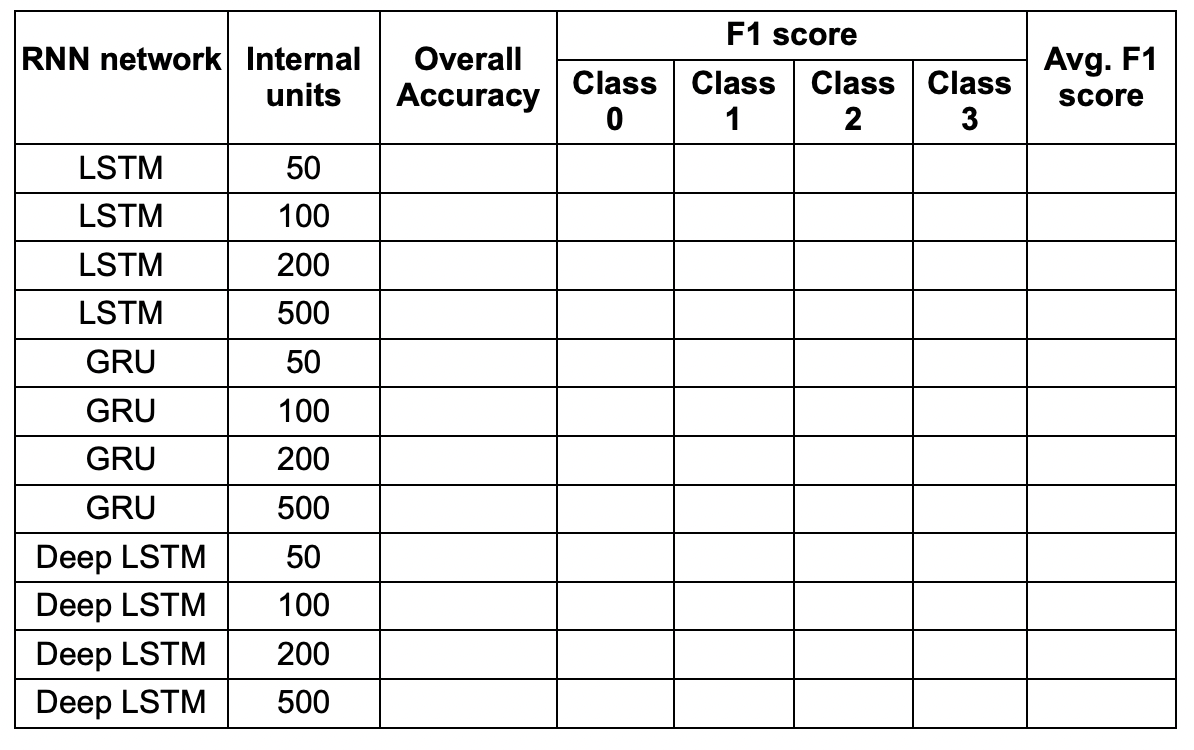